In [120]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pysam

In [13]:
ALIGNMENT_FILE = "lact.bam"
GENOME_LENGTH = 3079196

In [22]:
def write_to_wigfile(wigfile_header, wigfile_values, file_name):
    wigfile_content = wigfile_header + "\n"
    
    for wigfile_value in wigfile_values:
        wigfile_content += wigfile_value + "\n"
    
    with open(file_name, 'w') as the_file:
        the_file.write(wigfile_content)

In [163]:
# Physical coverage

def physical_coverage(samfile):
    genome_change = [0] * GENOME_LENGTH
    for read in samfile:
        # Check for left mate pair and SAM flags: 0x1 and 0x2
        if (read.template_length > 0 and read.is_paired and read.is_proper_pair):
            genome_change[read.reference_start] += 1
            genome_change[read.reference_start + read.template_length] -= 1


    current_coverage = 0
    physical_coverage_values = []

    for position in range(GENOME_LENGTH):
        current_coverage += genome_change[position]
        physical_coverage_values.append(current_coverage)

    return physical_coverage_values

In [141]:
samfile = pysam.AlignmentFile(ALIGNMENT_FILE)

physical_coverage_values = physical_coverage(samfile)

write_to_wigfile(wigfile_header="fixedStep chrom=genome start=1 step=1 span=1", 
                     wigfile_values=list(map(str, physical_coverage_values)),
                     file_name="physical_coverage.wig")

In [164]:
# Sequence coverage

def sequence_coverage(samfile):
    genome_change = [0] * GENOME_LENGTH
    for read in samfile:
        # Check for SAM flags: 0x1 and 0x2
        if (read.is_paired and read.is_proper_pair):
            genome_change[read.reference_start] += 1
            genome_change[read.reference_end] -= 1


    current_coverage = 0
    sequence_coverage_values = []

    for position in range(GENOME_LENGTH):
        current_coverage += genome_change[position]
        sequence_coverage_values.append(current_coverage)
        
    return sequence_coverage_values

In [144]:
samfile = pysam.AlignmentFile(ALIGNMENT_FILE)

sequence_coverage_values = sequence_coverage(samfile)

write_to_wigfile(wigfile_header="fixedStep chrom=genome start=1 step=1 span=1", 
                     wigfile_values=list(map(str, sequence_coverage_values)),
                     file_name="sequence_coverage.wig")

In [93]:
# Lengths of genomic insert
samfile = pysam.AlignmentFile(ALIGNMENT_FILE)

insert_lengths = []
for read in samfile:
    # Check for left mate pair and SAM flags: 0x1 and 0x2
    if (read.template_length > 0 and read.is_paired and read.is_proper_pair):
        insert_lengths.append(read.template_length)

In [131]:
lengths_mean = np.mean(insert_lengths)
lengths_std = np.std(insert_lengths)

print("Lengths mean is: " + str(lengths_mean))
print("Lengths std is: " + str(lengths_std))

Lengths mean is: 2101.273492569815
Lengths std is: 205.45154594269033


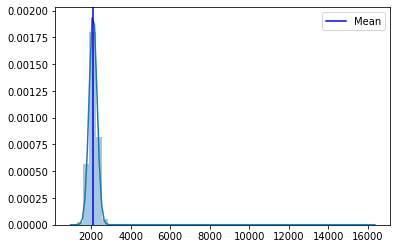

In [133]:
sns.distplot(insert_lengths)
plt.axvline(lengths_mean, color='b', linestyle='-')
plt.legend({'Mean': lengths_mean})

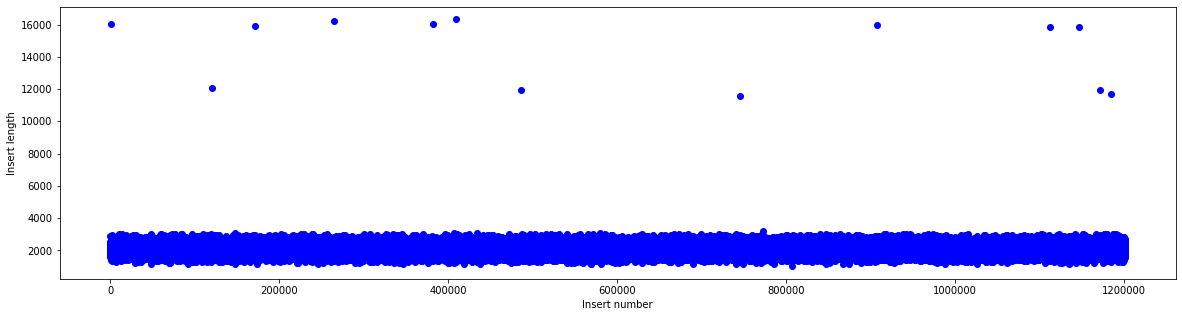

In [135]:
plt.figure(figsize=(20,5))
plt.plot(insert_lengths, "bo")

plt.xlabel('Insert number')
plt.ylabel('Insert length')

plt.show()

In [208]:
# Average length of the physical inserts track (for each bp)

def average_insert_length(samfile):
    physical_coverage_values = np.array(physical_coverage(samfile))

    # reset iterable to start from the beginning
    samfile = pysam.AlignmentFile(ALIGNMENT_FILE)

    insert_length_sums = np.zeros(3079196)

    for read in samfile:
        # Check for left mate pair and SAM flags: 0x1 and 0x2
        if (read.template_length > 0 and read.is_paired and read.is_proper_pair):
            insert_length_sums[read.reference_start: (read.reference_start + read.template_length)] += read.template_length

    average_length_per_base = insert_length_sums / physical_coverage_values
    average_length_per_base[np.isnan(average_length_per_base)] = 0

    return average_length_per_base

In [209]:
samfile = pysam.AlignmentFile(ALIGNMENT_FILE)

average_insert_length_values = average_insert_length(samfile)

write_to_wigfile(wigfile_header="fixedStep chrom=genome start=1 step=1 span=1", 
                     wigfile_values=list(map(str, average_insert_length_values)),
                     file_name="average_insert_length.wig")

/Users/neil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/Users/neil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


In [226]:
# Track with the percentage of inserts with a length exceeding n standard deviations (n=2) above or below the mean

def unusual_inserts(samfile):
    number_of_unusual_inserts = np.zeros(3079196)
    range_of_usual_inserts = range(int(lengths_mean - 2 * lengths_std), int(lengths_mean + 2 * lengths_std))
    
    for read in samfile:
        # Check for left mate pair and SAM flags: 0x1 and 0x2
        if (read.template_length > 0 and read.is_paired and read.is_proper_pair):
            number_of_unusual_inserts[read.reference_start: (read.reference_start + read.template_length)] += read.template_length not in range_of_usual_inserts

    # reset iterable to start from the beginning
    samfile = pysam.AlignmentFile(ALIGNMENT_FILE)
    
    physical_coverage_values = np.array(physical_coverage(samfile))
            
    percentage_of_unusual_inserts = number_of_unusual_inserts / physical_coverage_values
    percentage_of_unusual_inserts[np.isnan(percentage_of_unusual_inserts)] = 0
    
    return percentage_of_unusual_inserts

In [227]:
samfile = pysam.AlignmentFile(ALIGNMENT_FILE)

unusual_insert_values = unusual_inserts(samfile)

write_to_wigfile(wigfile_header="fixedStep chrom=genome start=1 step=1 span=1", 
                     wigfile_values=list(map(str, unusual_insert_values)),
                     file_name="unusual_inserts.wig")

/Users/neil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/Users/neil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


In [230]:
# Unique reads - reads with MAPQ value != 0

def unique_reads(samfile):
    genome_change = [0] * GENOME_LENGTH
    
    for read in samfile:
        # Check for MAPQ != 0 (unique read) SAM flags: 0x1 and 0x2
        if (read.mapping_quality != 0 and read.is_paired and read.is_proper_pair):
            genome_change[read.reference_start] += 1
            genome_change[read.reference_end] -= 1


    current_coverage = 0
    sequence_coverage_values = []

    for position in range(GENOME_LENGTH):
        current_coverage += genome_change[position]
        sequence_coverage_values.append(current_coverage)
        
    return sequence_coverage_values

In [231]:
samfile = pysam.AlignmentFile(ALIGNMENT_FILE)

unique_reads_coverage = unique_reads(samfile)

write_to_wigfile(wigfile_header="fixedStep chrom=genome start=1 step=1 span=1", 
                     wigfile_values=list(map(str, unique_reads_coverage)),
                     file_name="unique_reads_coverage.wig")

In [232]:
# Multiple reads (Ambiguous reads) - reads with MAPQ value = 0

def multiple_reads(samfile):
    genome_change = [0] * GENOME_LENGTH
    
    for read in samfile:
        # Check for MAPQ == 0 (unique read) SAM flags: 0x1 and 0x2
        if (read.mapping_quality == 0 and read.is_paired and read.is_proper_pair):
            genome_change[read.reference_start] += 1
            genome_change[read.reference_end] -= 1


    current_coverage = 0
    sequence_coverage_values = []

    for position in range(GENOME_LENGTH):
        current_coverage += genome_change[position]
        sequence_coverage_values.append(current_coverage)
        
    return sequence_coverage_values

In [233]:
samfile = pysam.AlignmentFile(ALIGNMENT_FILE)

multiple_reads_coverage = multiple_reads(samfile)

write_to_wigfile(wigfile_header="fixedStep chrom=genome start=1 step=1 span=1", 
                     wigfile_values=list(map(str, multiple_reads_coverage)),
                     file_name="multiple_reads_coverage.wig")